In [1]:
from edc import check_compatibility
check_compatibility("user-2022.02", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


# Sentinel-2 based object detection (ships and parked planes)

This Jupyter notebook aims at showing the steps implemented to run teh Ships and Airplanes detection algorithm.
The detection algorithms are base on AI neural network and have been trained with more than 200 dedicated training datasets. Then they have been implemented as Headless notebook, and thus it has the following characteristics:

Stateless execution (no need of having a stable connection all the time while the script is running)
Easy to share the algorithm progress without having to share the source code 
Run via postman specifying script path and parameters
Easy to run complex scripts that take long time to run such as AI training algorithms

In this context the Ship detection and Airplane detection agorithms are under service licence, thus the complete workflow is not executable. For this reason we are showing here the necessary steps and parameters to interact with the Headless notebook, without the possibility to run the detections.

The approach implemented for this type of computation is based on the following 2 main step of workflow:

STEP 1: Set-up and input acquisition
- Import of necessary libraries
- set up of generic input parameters
    - Area of Interest - AOI (wkt polygon)
    - indicator code
    - sensor
    - overalpping AOI %
    - Cloud coverage % (global, over the entire image)
    - time range of interest
- set up of credentials for accessing and using EDC services
- core for generating the parameters necessary for triggering the AI algorithm:
    - generic input parameters
    - filtering of S2 images
        - covering the specific time range
        - over defined AOI with overlapping %
        - with defined Cloud Coverage % (global, over the entire image)
        - sensor

STEP 2: Pre-processing and object detection task execution
- Filtering S2 images according to cloudiness over AOI
- Send the encoded package to WPS endpoint for triggering the object detection algorithm (DL-based)
    - creation of CSV ready for timeseries ingestion into GeoDB
    - creation of geojson file with detection polygons
- Removing cloud-covered detected objects
      

The Following JN will cover and demonstrate the STEP 1 for the preparation fo the necessary parameters and the filtering of the Sentinel 2 Images that match the requirements specified in the generic input parameters

# STEP 1: Set-up and input acquisition

# Import of necessary libraries

In [2]:
# Import packages
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import requests
import csv
import base64
import datetime
from shapely import wkt, geometry
#from shapely.geometry import shape, polygon
from shapely.geometry.multipolygon import MultiPolygon
from collections.abc import Iterable
from xml.etree import ElementTree
from IPython.display import clear_output
import geojson

# set up of credentials for accessing and using EDC services
- <ins>aoisfile</ins>: is a csv file with information about extended name of the Location (text), the AOI_ID (is a text with the identified code specific for that location), the economic indicator code (is a text with the identified code for the specific indicator), AOI Polygon (is a simplified polygon for intersecting the Sentinel 2 images covering the AOI, since there is a limitation on the points to be used for this computation, it is reccomended to use a rectangular or very simplified polygon), AOI subPolygon is the exact polygon of the AOI in which the algorithm will detect the features, it is reccomended to provide a polygon as much detailed as possible in order to reduce false positive outside the AOI).
- <ins>indicator</ins>: The indicator code that shall match one of the indicator code avaialbe in the aoisfile
- <ins>sensor</ins>: currently it has been implemented for Sentinel 2
- <ins>SENTINEL_2_L2A_collection_id</ins>: the collection ID as in sentinel HUB (default value = DSS2)
- <ins>overlap_perc</ins>: percetange of overalpping between Senteinel 2 image and the AOI polygon
- <ins>max_cc</ins>: the max cloud coverage over which the Sentinel 2 scene will be discarded 
- <ins>fromdate</ins>: start of the Time range for which we want to select Sentienl 2 scenese
- <ins>todate</ins>: end of the Time range for which we want to select Sentienl 2 scenese

In [3]:
# Parameters
# aoisfile = "./Inputs/ships/Ships_Input_for_WPS_call.csv"
indicator = 'E200'
sensor = 'sentinel2'
SENTINEL_2_L2A_collection_id = "DSS2"
overlap_perc = 80
max_cc = 20
fromdate = "2022-01-01T00:00:00"
todate = "2022-04-20T23:59:05"

# Set UP of the EDC credentials

In [4]:
import os

client_id = os.environ['SH_CLIENT_ID']
client_secret = os.environ['SH_CLIENT_SECRET']

In [5]:
token_url ='https://services.sentinel-hub.com/oauth/token'
token_info = "https://services.sentinel-hub.com/oauth/tokeninfo"

def get_token (client_id, client_secret, token_url, token_info):
    client = BackendApplicationClient(client_id=client_id)
    oauth = OAuth2Session(client=client)
    token = oauth.fetch_token(token_url=token_url,
                              client_id=client_id, client_secret=client_secret)
    resp = oauth.get(token_info)
    return oauth

oauth = get_token (client_id, client_secret, token_url, token_info)

In [6]:
aois = [
    ['Hamburg Port', 'DE1', 'E1', 'MULTIPOLYGON (((9.9914568218085 53.5507436648936,10.0083453537234 53.5480049840426,10.066998768617 53.5208463989362,9.99624951329786 53.4505535904256,9.93325985372342 53.4763428351064,9.92960827925534 53.4927749202128,9.85429455585112 53.5005345159575,9.80796520478732 53.5265519840426,9.84790430053198 53.5541670159575,9.92390269414896 53.5500589946809,9.9914568218085 53.5507436648936)))', 'MULTIPOLYGON(((9.93482324575326 53.52217292910398,9.93353578542611 53.51962148503035,9.927012653101892 53.51273181845782,9.93156167959115 53.51104750734582,9.934479922999353 53.5132422025482,9.934651584376306 53.511787591685405,9.937226505030603 53.51165999185931,9.941260547389001 53.51140479105447,9.94005891775033 53.5215605965405,9.937655658472986 53.521713680511134,9.93482324575326 53.52217292910398)), ((9.93482324575326 53.52217292910398,9.93353578542611 53.51962148503035,9.927012653101892 53.51273181845782,9.93156167959115 53.51104750734582,9.934479922999353 53.5132422025482,9.934651584376306 53.511787591685405,9.937226505030603 53.51165999185931,9.941260547389001 53.51140479105447,9.94005891775033 53.5215605965405,9.937655658472986 53.521713680511134,9.93482324575326 53.52217292910398)), ((9.952375621546716 53.52814270776398,9.952976436366052 53.52569366958306,9.952804774989099 53.52130545536001,9.951688976038904 53.51977457600807,9.958383769740076 53.51834570536899,9.958383769740076 53.52472421951584,9.959156245936365 53.52411192383071,9.959413738001794 53.51962148503035,9.960958690394373 53.51972354574362,9.968082637537927 53.524009873689366,9.969284267176599 53.52329551581608,9.962932796229333 53.519927666432636,9.961816997279138 53.51758021913205,9.962331981409998 53.51660757843397,9.967052669276208 53.515944130611764,9.969713420618982 53.517219982588095,9.97301790212533 53.52393033149755,9.97449848150155 53.52483601961122,9.974981279124231 53.52406427250918,9.972905249346704 53.51939203219843,9.971266419638605 53.51514191901033,9.97426244710824 53.51451513078855,9.976622791041345 53.51958020746646,9.977781505335779 53.52187013782167,9.977781505335779 53.524032381830466,9.979068965662927 53.52671111514041,9.978897304285974 53.52729786267592,9.976837367762537 53.52762949899182,9.97374746297738 53.527680519733,9.97052881215951 53.527884602083176,9.96902677511117 53.52766403032423,9.968179197062463 53.52718384114065,9.96677908395669 53.526554703035906,9.965008155454607 53.52651113783715,9.963544297975213 53.52704015785488,9.960921726201386 53.52818141697508,9.956406143505783 53.53023426422902,9.95651594643733 53.53138082093362,9.965637971658916 53.52717044628051,9.966541708458871 53.52670992721539,9.96749590431592 53.52724673267805,9.967913993646116 53.52746411191769,9.968203336943597 53.527732510720234,9.967717857111902 53.52823427547219,9.966926542588235 53.52911882125499,9.966242516425163 53.52969723998385,9.965461930737556 53.53054986944036,9.956978040759177 53.53401698264113,9.957675163645954 53.534315388163456,9.965539149020524 53.53111930086922,9.96745412052861 53.5302864372441,9.96848932747981 53.53041014470933,9.969668493617982 53.5312594965572,9.969537735928506 53.53354481014109,9.963997633208246 53.53561559469329,9.957809777010889 53.53797160668574,9.958424002875299 53.53988118732603,9.95808738564393 53.540759437985436,9.957149953593225 53.54168867429014,9.953958124865503 53.54160579297827,9.949006767024011 53.5414464053839,9.949500293482751 53.53846255884876,9.952461452235193 53.53411654505941,9.955422610987634 53.528775218712035,9.952375621546716 53.52814270776398)))'],
    ['Hamburg Port', 'DE1', 'E1a', 'MULTIPOLYGON (((9.9914568218085 53.5507436648936,10.0083453537234 53.5480049840426,10.066998768617 53.5208463989362,9.99624951329786 53.4505535904256,9.93325985372342 53.4763428351064,9.92960827925534 53.4927749202128,9.85429455585112 53.5005345159575,9.80796520478732 53.5265519840426,9.84790430053198 53.5541670159575,9.92390269414896 53.5500589946809,9.9914568218085 53.5507436648936)))', 'MULTIPOLYGON(((9.966443610596757 53.475382083347526,9.963482451844316 53.4758929171677,9.96661527197371 53.482456584547016,9.972237182068925 53.479902749047874,9.976957869935136 53.47791065063858,9.983008933472734 53.47660807418479,9.981721473145585 53.47367074524262,9.978889060425859 53.47433485479109,9.978245330262284 53.473313143488696,9.97712953131209 53.47262347445362,9.976271224427324 53.47119301405827,9.974495629802993 53.470077038148695,9.97183487846022 53.47056239109158,9.974195222393325 53.47452164198526,9.973251084820083 53.47618186308022,9.972264031902602 53.47590090715328,9.971148232952407 53.47365319276894,9.971362809673598 53.47291244262838,9.970289926067641 53.47102219402294,9.966427545086196 53.471788521172286,9.968487481609634 53.47605415607132,9.968873719707778 53.4778675595776,9.967457513347915 53.47819958281157,9.966443610596757 53.475382083347526)), ((9.935080295425847 53.5126724537116,9.94149613938947 53.51283832944758,9.942687040192082 53.504588414730314,9.943883305412724 53.49931413602895,9.941818004471257 53.49646454004884,9.936153179031804 53.49620924774728,9.935080295425847 53.5126724537116)))'],
    ['Hamburg Port', 'DE1', 'E2', 'MULTIPOLYGON (((9.9914568218085 53.5507436648936,10.0083453537234 53.5480049840426,10.066998768617 53.5208463989362,9.99624951329786 53.4505535904256,9.93325985372342 53.4763428351064,9.92960827925534 53.4927749202128,9.85429455585112 53.5005345159575,9.80796520478732 53.5265519840426,9.84790430053198 53.5541670159575,9.92390269414896 53.5500589946809,9.9914568218085 53.5507436648936)))', 'MULTIPOLYGON (((9.93956941558187 53.5217398605945,9.95506514860212 53.5185858138924,9.95478705374351 53.5165001024528,9.95978458529656 53.515092396839,9.96718371579047 53.5134097957354,9.96651498971085 53.5099583062922,9.96653656151987 53.5072186865467,9.96737300140238 53.5056031615769,9.96876196894976 53.5042955299234,9.97285604655623 53.5023374928073,9.98190261344477 53.5016623207361,9.98776196618729 53.4979097015639,9.98670859940211 53.4862568315029,9.98730111821877 53.4759865053475,9.96698920069631 53.4797878881813,9.96505077727052 53.4767417942264,9.96746391663733 53.4764253169324,9.96546890652716 53.4717209124458,9.95229665683677 53.4738569529361,9.95728075131422 53.4825791182717,9.94677855223674 53.4895212498653,9.95024961803354 53.4950393544653,9.94161386928344 53.4972473592203,9.95105063321741 53.5041175265492,9.95283066695936 53.5047405383589,9.94989361128515 53.511237661517,9.94001442401735 53.5174677796138,9.93956941558187 53.5217398605945)))'],
    ['Hamburg Port', 'DE1', 'E200', 'MULTIPOLYGON (((9.9914568218085 53.5507436648936,10.0083453537234 53.5480049840426,10.066998768617 53.5208463989362,9.99624951329786 53.4505535904256,9.93325985372342 53.4763428351064,9.92960827925534 53.4927749202128,9.85429455585112 53.5005345159575,9.80796520478732 53.5265519840426,9.84790430053198 53.5541670159575,9.92390269414896 53.5500589946809,9.9914568218085 53.5507436648936)))', 'MULTIPOLYGON(((9.985948849585329 53.47698696776841,9.985090542700563 53.479489900061935,9.984382439520632 53.47994960627022,9.984489727881227 53.48107331158823,9.982601452734743 53.49174702778084,9.982258129980837 53.493432105873936,9.983116436865602 53.49460651464634,9.98242979135779 53.49516817690974,9.980799008276735 53.49511711701137,9.980541516211305 53.495780890894316,9.982086468603883 53.49629147911842,9.978824902441774 53.49899749406335,9.977365780737673 53.50139702321567,9.978224087622438 53.50190754381174,9.9747050293949 53.50277541471585,9.970585156348024 53.50471529719899,9.970499325659548 53.50788017804342,9.97745161142615 53.52502768016079,9.981743145849977 53.52242538101643,9.984489727881227 53.52334385779271,9.98294477548865 53.52456846251665,9.981313992407594 53.52609916863645,9.97916822519568 53.52620121374429,9.977794934180055 53.52711960865182,9.976335812475954 53.53472111295407,9.979597378638063 53.53900592335531,9.983373928931032 53.53798576973372,9.984597016241823 53.537552197000906,9.984382439520632 53.537054858104575,9.984833050635133 53.536455493210504,9.983545590307985 53.53492516137746,9.983030606177126 53.531966362996265,9.985262204077516 53.53181331607731,9.985777188208376 53.5352822437524,9.987236309912477 53.53686357235805,9.988523770239626 53.53620044174598,9.987837124731813 53.53125213930885,9.989639569189821 53.53099705650118,9.990068722632204 53.53421098759355,9.992128659155641 53.53227245517481,9.99367361154822 53.531379680136496,9.994531918432985 53.531864331778436,9.998222638037477 53.529466527389175,10.001297981724866 53.52970862796026,10.001859425480752 53.52999238651024,10.000189271336287 53.53113067906346,9.99384488895064 53.534784522898676,9.99375177771324 53.53767924516172,9.989438785617292 53.53883330047661,9.985683692996442 53.539910815438475,9.982679618899763 53.540637644361524,9.980276359622419 53.54131345655033,9.975147975985944 53.54280530563869,9.971371425692976 53.54364683834067,9.967959655826032 53.54422060104537,9.965320362155378 53.54427160179829,9.961930049960554 53.544513854535545,9.960084690158308 53.544717855765214,9.956823123996198 53.54438635326773,9.953861965243757 53.543876344355844,9.950493110721052 53.54326432555006,9.948883785312116 53.54307306785857,9.946952594821393 53.54312406999415,9.94579388052696 53.54311131946599,9.944570793216169 53.54317507206825,9.94403435141319 53.54265229789544,9.942875637118757 53.542550292425986,9.940729869906843 53.5423845330139,9.935258163516462 53.54239728376096,9.932275547091901 53.54243553597905,9.924872650210798 53.54228252689925,9.918413890902936 53.54193825444754,9.91283489615196 53.54204026139178,9.907942546908796 53.54206576308944,9.903565181796491 53.542218772952715,9.89416386908393 53.542178124278465,9.881975911320259 53.54222912749234,9.874422810734321 53.54273915625098,9.870496056736519 53.54314717483344,9.869187069075096 53.54322285192714,9.869294357435692 53.54077468581561,9.871633243696678 53.53944853672154,9.874508571760643 53.53822436222419,9.875624370710838 53.537204189769994,9.876654338972557 53.53669409432467,9.877383899824608 53.536821618762154,9.88081712736367 53.53419453780861,9.881932926313866 53.53419453780857,9.882190418379295 53.53370991283539,9.881289196150291 53.532868182594164,9.88407869352578 53.53189889674129,9.884851169722069 53.5323580349109,9.887190055983055 53.53086581765844,9.888670635359276 53.52960313122087,9.888026905195701 53.52853173138653,9.88879938139199 53.52661844998192,9.887726497786034 53.52615924958396,9.887211513655174 53.521107716624954,9.885194492475975 53.518632755878784,9.888284397261131 53.51830104912151,9.890687656538475 53.518403113015744,9.894464206831444 53.520087131773224,9.896524143354881 53.519525799624844,9.897597026960838 53.51993404192492,9.899828624861229 53.5196023453558,9.90128774656533 53.5201891913648,9.899399471418846 53.521311830644976,9.894464206831444 53.52330189080154,9.893090915815819 53.526490894815204,9.893498611586082 53.52788122540634,9.89382047666787 53.529246000954295,9.893492284925207 53.531463710169504,9.881733480603918 53.53712612454513,9.883750501783117 53.537253647681396,9.884351316602453 53.539128193461785,9.88293511024259 53.5398295327919,9.889715734632238 53.53953624684908,9.896496359021887 53.5394469855067,9.900101247937902 53.53768722347154,9.900248721866891 53.53686732219485,9.88552875879316 53.53732640649388,9.885914996891305 53.5353370052467,9.900334552555368 53.53472486298057,9.914282039432809 53.52922793905411,9.926942065983102 53.52398542814839,9.928572849064157 53.52522277024456,9.929602817325875 53.52666416442764,9.927371219425485 53.52799071395819,9.910076335697457 53.53508194704465,9.91024799707441 53.53918819734306,9.906246141224191 53.539258331699536,9.90627832773237 53.53949423731854,9.914453700809762 53.539290210914075,9.927027896671579 53.53880564426266,9.93475265863447 53.534622838409206,9.935954288273141 53.530643688377175,9.935610965519235 53.51921430687139,9.928315356998727 53.513345345929366,9.929946140079782 53.51268184702815,9.931834415226266 53.51199281794283,9.934666827945993 53.514238501122186,9.935954288273141 53.51416194570047,9.936812595157907 53.49777590349868,9.939387515812204 53.49675475665194,9.948099330692575 53.49525771805712,9.95144672754316 53.49119827285885,9.9549657857707 53.487049067277624,9.953268814947878 53.48776384975501,9.95144672754316 53.48874709893559,9.949901775150582 53.48859389586169,9.949000552921579 53.487853406536686,9.956381992130563 53.48519775230039,9.958613590030954 53.48315482820986,9.9529487645915 53.4748799795162,9.955914439094276 53.47398148164546,9.958193468089238 53.477118602968936,9.961635727128968 53.481451291709554,9.963120822255522 53.481089242967705,9.96426259462817 53.48016533761376,9.961052975310967 53.47326022977217,9.963921514033363 53.472662169777934,9.967169501512334 53.47907751400066,9.96955918210654 53.47794540035342,9.969888926177308 53.476583387026615,9.96751718285589 53.47210557266055,9.969983474045083 53.471681104143556,9.970796183376596 53.4730800181746,9.97070498827009 53.47347673461682,9.972582534580514 53.476671084771674,9.974277690677926 53.47606128737057,9.974578098087594 53.47392213819509,9.973118976383493 53.470869672963595,9.975093082218454 53.47028214400027,9.977603629856393 53.47400515196524,9.978869632511422 53.47412647949102,9.979212955265329 53.4748799795162,9.99191589715986 53.47191698703108,9.992945865421579 53.47549298661571,9.985948849585329 53.47698696776841), (9.946445410839022 53.51556820941771,9.94421271700129 53.51761264559365,9.967043680136056 53.5130704795874,9.967387002889962 53.51449952812918,9.941822689984514 53.51991692820946,9.941736859296038 53.522009109099976,9.94216601273842 53.52371849727344,9.942208928082659 53.52518545451134,9.942230385754778 53.53005156188974,9.941039484952165 53.534729003067405,9.939196807358934 53.53707151502406,9.935637515996172 53.539515910410536,9.946411949608995 53.53823674490435,9.949910891268923 53.53264900844839,9.953205314491465 53.52592628847234,9.953822557841017 53.52103369444248,9.952946900416686 53.52088207808547,9.948560860034599 53.521954406443236,9.946668247253223 53.522618127656905,9.94258912073314 53.52333268070172,9.942352001931107 53.52223570049336,9.951642089549972 53.519965018035805,9.957358044598772 53.51859012581514,9.958473843548967 53.51935559380595,9.958216351483538 53.52037619628039,9.958044690106584 53.52542781646919,9.959932965253069 53.52476450676227,9.959589642499163 53.52017207775243,9.960791272137834 53.52027413713933,9.968258542035295 53.52445836031723,9.969803494427874 53.524611433816354,9.969202679608538 53.52308067393258,9.963022870038225 53.52007001811965,9.961220425580217 53.51711018181681,9.966456097577288 53.51619156988589,9.968945187543108 53.51680398005269,9.970490139935686 53.51828393474638,9.973236721966936 53.524509384878414,9.9726359071476 53.52757074607181,9.969460171673967 53.5272135986671,9.966284436200334 53.52634622814608,9.964310330365374 53.52634622814608,9.956328076337053 53.52991763981072,9.955727261517717 53.531550184840306,9.956585568402483 53.531652216815054,9.962507885907366 53.52915236266365,9.961821240399553 53.528591150633666,9.966713589642717 53.526856448250804,9.968172711346819 53.527621766883804,9.96465365311928 53.530733920192276,9.956843060467913 53.53420293628839,9.957615536664202 53.53471306174588,9.968430203412249 53.53012171138113,9.968859356854631 53.53348875032316,9.962078732464983 53.5358353161197,9.9561564149601 53.53802872742089,9.957873028729631 53.53864082192257,9.957873028729631 53.54037504162062,9.953238171551897 53.54088509271804,9.966456097577288 53.5421091902793,9.964567822430803 53.53843679140526,9.969717663739397 53.53670249230871,9.97066180131264 53.52981560365674,9.972206753705217 53.53007069358071,9.971434277508928 53.53726359684927,9.97212092301674 53.53853880678683,9.970747632001116 53.53904888000741,9.969546002362444 53.537977719146284,9.966971081708147 53.53879384416528,9.969031018231584 53.54154814995754,9.97512499711342 53.539864984377935,9.97289339921303 53.53721258765287,9.974266690228655 53.53690653118384,9.976412457440569 53.53925290757491,9.977442425702288 53.538895858686466,9.97512499711342 53.53593733776965,9.974095028851702 53.53649845245032,9.972464245770647 53.53603935917379,9.973923367474749 53.53440698720885,9.973923367474749 53.533692804685195,9.972807568524553 53.53374381812209,9.972979229901506 53.532570493525256,9.974781674359514 53.53272353770771,9.975768727276995 53.52723910929589,9.973794621442034 53.52670338286473,9.973708790753557 53.52545332817356,9.974824589703752 53.525249234108394,9.974481266949846 53.52358272402144,9.974910420392229 53.52320002994278,9.9726359071476 53.51743368735373,9.971005124066545 53.51501596818684,9.970060986493303 53.51351038046275,9.969546002362444 53.51305103796501,9.96963183305092 53.5119792194403,9.96662775895424 53.50462887640256,9.967099827740862 53.50248478622808,9.97239987275429 53.50124678001739,9.974781674359514 53.49970241231423,9.975425404523088 53.49735384451596,9.976712864850237 53.49517109150677,9.980038804028704 53.49092333632457,9.980929297421648 53.48282397658492,9.979657930348589 53.482553439259796,9.980138045762255 53.48154988234271,9.980678510878755 53.48117578696074,9.982665357206537 53.48063119794717,9.983057965551092 53.47974596401408,9.982310132150127 53.479099023753655,9.98305201439984 53.477140971102244,9.978015622150673 53.4783073321839,9.972579182617887 53.48037177935527,9.966241520856096 53.48330439554733,9.96139208695717 53.48646129909805,9.956049126599504 53.492788762804146,9.95964328667946 53.49222467542752,9.95989541432686 53.49362769924662,9.954356652711107 53.49468661838808,9.952445578787996 53.49700312373314,9.95024549684353 53.4989782212941,9.946141381774618 53.50185469484152,9.943960578207447 53.50433937223356,9.94317058383353 53.50701095739341,9.942389348548426 53.51130713529841,9.942170392282828 53.514909614571565,9.947468247524052 53.510560705238085,9.949559275669566 53.50593590277473,9.9462196517245 53.50319709666904,9.947616343638623 53.50155514998912,9.949356358306654 53.50006630189839,9.95195467985945 53.50181931848273,9.954069232176375 53.49942842229523,9.958173497775755 53.4998156355902,9.95859484749439 53.50122175697934,9.95603748265034 53.50348184939937,9.955466903408245 53.504496991154646,9.964751735552335 53.50296258282969,9.9663900775277 53.5026292925663,9.965664296122805 53.50506617177187,9.964142691125923 53.50585066153207,9.957557075508925 53.50706902605372,9.955512684796526 53.508508382965225,9.958847945323885 53.51023468491333,9.95721716224283 53.51102582424915,9.95472807227701 53.51117894628573,9.951766913524569 53.511485188699126,9.946445410839022 53.51556820941771)))'],
]

# Core for generating the parameters necessary for triggering the AI algorithm

The following code will filter Sentinel 2 scenes according to paramters, displaying information of the AOI_ID, the overlapping percentage, the Cloud Coverage percentage and then providing the dates corresponding to avaialbe Sentienl 2 scenes matching the set parameters.

The output list could contains duplicated dates for which 2 sentinel images with two different UTM zones. In this case it is filtered on the first image with lowest cloud coverage. This approach has been implemented since the AI algortihm run on each provided image, that if not filtered, will cause duplicated counts on the same AOI and date but with different time.  

In [7]:
basesearch_url = f"https://creodias.sentinel-hub.com/ogc/wfs/e85faeeb-72ce-4de6-984c-c6dd0ede3ee0?"
for line in aois:
        count = 0
        dates=[]
        indicator_from_file = line[2]
        if indicator == indicator_from_file:
            aoiid = line[1]
            #print(line[1])

            pol = wkt.loads(str(line[3]))
            pol_subAOI = wkt.loads(str(line[4]))
            #Multipolyg to Polyg
            if isinstance(pol, Iterable):
                polyg = list(pol)[0].wkt
            else:
                polyg = pol.wkt
            g1 = wkt.loads(polyg)
            geom1 = geometry.shape(g1)
            offset=0
   
            multi_poly = str(MultiPolygon([geom1]))
            print('AoI id:', aoiid)
            if aoiid == 'EG1':
                overlap_perc = 30
            while True:
                search_url = f"{basesearch_url}\
service=WFS&version=1.0.0&request=GetFeature&\
typenames={SENTINEL_2_L2A_collection_id}&\
outputformat=application/json&\
FEATURE_OFFSET={offset}&\
GEOMETRY={polyg}&\
time={fromdate}/{todate}&srsname=EPSG:4326&\
maxcc={max_cc}"

                try:
                    response = oauth.get(search_url)
                    response.raise_for_status()
                    results = response.json()
                except requests.exceptions.HTTPError as e:
                    print (f"Error {e.response.content}")
                    break      
                feats = len(results['features'])
                if feats == 0:
                    break
                    #pagination
                count = count+feats
                offset = offset+100
                for subfeature in results['features']:
                    geom2 = geometry.shape(subfeature['geometry'])
                    overlap = geom1.intersection(geom2).area/geom1.area*100
                    ftime_out = subfeature['properties']['time']
                    print('overlap: ', overlap)
                    if overlap >= overlap_perc:
                        fdate = subfeature['properties']['date']
                        if fdate in dates and aoiid != "EG1" and aoiid != "EG2":
                            print ("Found duplicate")
                            continue
                        dates.append(fdate)
                        ftime = subfeature['properties']['time']
                        

print('\nFiltered dates:\n', dates)

/tmp/ipykernel_69/529812178.py:14: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  polyg = list(pol)[0].wkt
/tmp/ipykernel_69/529812178.py:14: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polyg = list(pol)[0].wkt


AoI id: DE1


overlap:  85.91614427870401
overlap:  99.99999999999997
overlap:  78.75822669538233
overlap:  99.99999999999997
overlap:  80.9940408648655
overlap:  80.9940528041266
overlap:  99.99999999999997
overlap:  80.85777629868278
overlap:  99.99999999999997
overlap:  99.99999999999997
overlap:  84.50087594168775
overlap:  99.99999999999997



Filtered dates:
 ['2022-04-17', '2022-03-25', '2022-03-20', '2022-03-18', '2022-03-13', '2022-03-10', '2022-03-08', '2022-03-05', '2022-02-28', '2022-02-26', '2022-02-23']


# STEP 2: Pre-processing and object detection task examples

As previously mentioned, the cloud and object detection (ships and airplanes) algorithm is under service licence and the complete workflow is thus not executable.
For this reason we are showing here some representative examples of the outputs generated by these algorithms. 

# Cloud detection module
Features
- Performing cloud detection over AOI
- Assessing percentage of clouds (PoC) and filtering out cloudy images (above a specified cloudiness threshold)
- Removing cloud-covered detected objects (post-processing step)

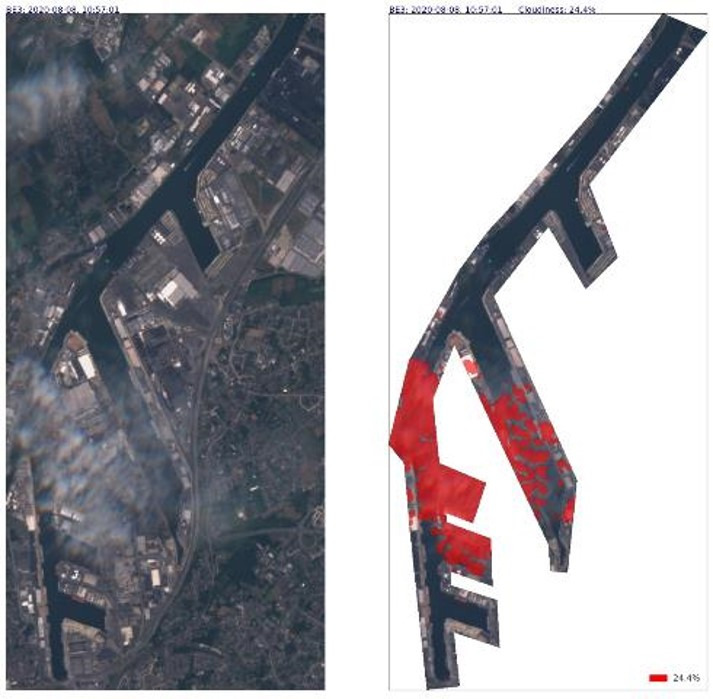


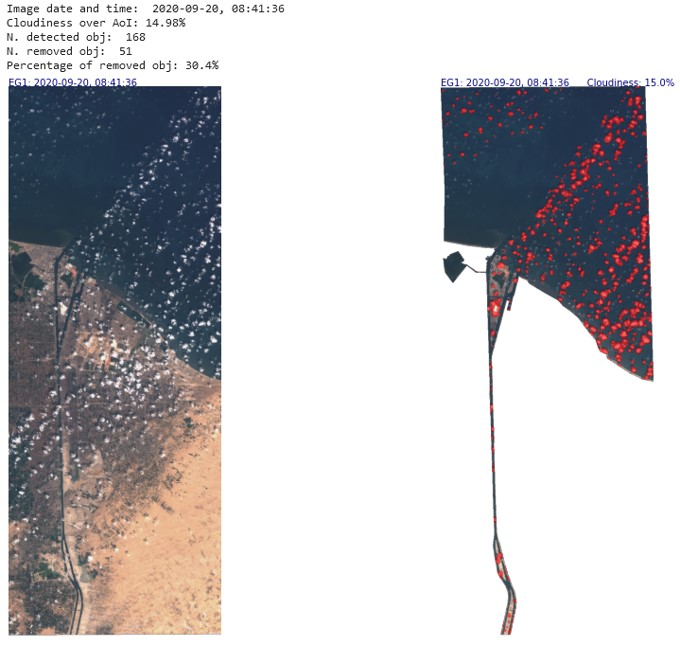

# Object detection module

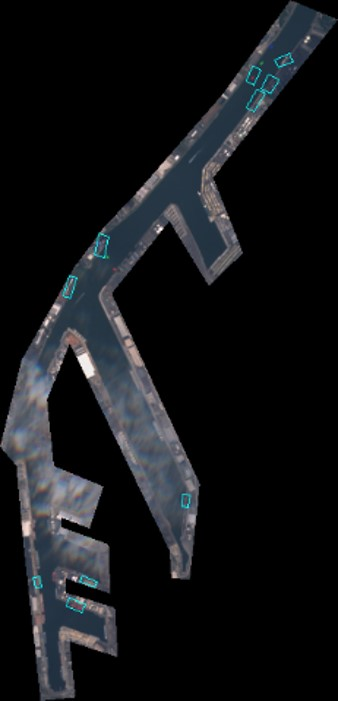

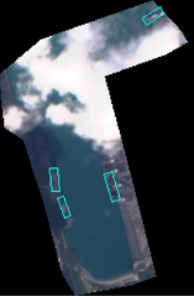